In [1]:
#amazon food review analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import nltk
import warnings
warnings.filterwarnings("ignore")
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
import sqlite3

In [2]:
#load the dataset from database
conn = sqlite3.connect('./database.sqlite')

#filtering only positive and negative reviews i.e.
#not taking into consideration those review with score 3.
filtered_data = pd.read_sql_query("""
SELECT * FROM Reviews WHERE Score !=3
""",conn)

#give review with score >3 a positive rating and score<3 a negative rating
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
    
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative


In [3]:
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#data deduplication
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vikash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
print(filtered_data.shape)
print(filtered_data.head())

(525814, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several o

In [6]:
import gensim
from gensim.models import word2vec,KeyedVectors

In [7]:
#remove duplicate entries

In [8]:
dup_data=pd.read_sql_query("""SELECT * FROM REVIEWS WHERE score!=3 ORDER BY ProductId """,conn)

In [9]:
dup_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,4,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
1,150494,0006641040,AYZ0PR5QZROD1,Mother of 3 girls,3,3,5,1173312000,Family favorite,All of my children love this book. My first g...
2,150496,0006641040,A3KKR87BJ0C595,"Gretchen Goodfellow ""Lover of children's lit""",3,3,5,1111363200,"You'll use it once, you'll use it twice",One of my earliest memories is of this book. ...
3,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,1,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....
4,150498,0006641040,A3SJWISOCP31TR,R. J. Wells,2,2,5,1176336000,A Gem of a Book,This is a wonderful little book. I loved it 40...


In [11]:
#the product id 0006641040 is a book and not a fine food and hence to be removed
sort_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
sort_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [12]:
final_data=sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

In [14]:
percent=(final_data['Id'].size*1.0 / filtered_data['Id'].size*1.0) *100
print(percent)

69.25890143662969


In [15]:
final_data["Score"].value_counts()

positive    307063
negative     57110
Name: Score, dtype: int64

In [16]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


In [17]:
dup_data1=pd.read_sql_query("""SELECT DISTINCT ProductId,UserId FROM REVIEWS WHERE score!=3 AND ProductId='0006641040' ORDER By ProductId """,conn)

In [18]:
dup_data1.shape

(34, 2)

In [19]:
labels = final_data['Score']

In [20]:
labels.head(3)

138706    positive
138688    positive
138689    positive
Name: Score, dtype: object

# BOW,TFIDF,Word2Vec(Avg-W2Vec,TfIDF-W2Vec) t-SNE plots


In [21]:
#helper functions
stop_word = set(stopwords.words('english'))
sno = SnowballStemmer('english')

def cleanhtml(sentence):
    cleanh = re.compile('<.*?>')
    cleantext = re.sub(cleanh,' ',sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|,|)|(|\|/]',r'',cleaned)
    return cleaned   

print(stop_word)
print("***********************************")
print(sno.stem('tasty'))

{'off', 'why', 'your', 'what', 'd', 'you', 'itself', 'because', 'who', 'yourself', "shan't", "needn't", "aren't", 'there', 'so', 'do', 'wouldn', "it's", 'ma', 'the', 'such', 'their', 'nor', 'that', 'from', 'with', 'ours', 'should', 'an', 'myself', 'a', 'haven', 'into', 'both', 'she', "that'll", 'than', 'some', 'up', "you'll", "you've", 'below', "wasn't", 'had', 'hasn', 'ain', 'are', 'isn', 'don', 'these', 'we', 'again', 'very', 's', 'until', 'he', 'am', "she's", 'does', 'if', 'few', 'own', 'his', 'being', 'hers', 'it', 'those', 'hadn', 'themselves', 'in', 'they', "mightn't", "shouldn't", 'o', 'once', "couldn't", 'and', "hasn't", "you'd", 'me', 'about', "hadn't", 'can', 'shan', 'after', 'yours', 'how', 'not', "you're", 'will', 'between', 'y', 'all', 'or', 't', 'where', 'before', 'ourselves', 'against', 'be', 'but', 'mightn', 'wasn', 'most', 'which', 'other', 'theirs', 'couldn', 've', "mustn't", 'didn', 'our', 're', "wouldn't", 'to', 'as', 'at', 'here', 'll', 'now', 'no', 'were', 'each',

In [22]:
#code to check for implemented check above
i=0
str1=''
final_string = []
all_pos_words = []
all_neg_words = []
s=''

for sent in final_data['Text'].values:
    filtered_sentence =[]
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                s=(sno.stem(cleaned_words.lower())).encode('utf-8')
                filtered_sentence.append(s)
                if(labels.values)[i]=='positive':
                    all_pos_words.append(s)
                if(labels.values)[i]=='negative':
                    all_neg_words.append(s)
            else:
                continue
        else:
            continue
            
    str1=b" ".join(filtered_sentence)

    final_string.append(str1)
    i+=1

    

In [23]:
final_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final_data['CleanedText']=final_data['CleanedText'].str.decode("utf8")


In [24]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,this witti littl book make son laugh loud reci...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read these sendak book and watch the real...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,this fun way for children learn their month th...


In [25]:
#save it to database
conn=sqlite3.connect('final3.sqlite')
c=conn.cursor()
#c.execute("alter table REVIEWS add column '%s'" %labels)
conn.commit()
conn.text_factory=str
final_data.to_sql('Reviews',conn,schema=None,if_exists='replace')

In [26]:
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,this witti littl book make son laugh loud reci...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read these sendak book and watch the real...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,this fun way for children learn their month th...


In [27]:
n_samples = 2000
test_data = final_data.sample(n_samples)
label_data = final_data['Score'][0:2000]

In [28]:
test_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
105493,114554,B000MUU22O,ABAWFS1QJOCVO,aaron,0,1,negative,1303603200,Gross,This mango syrup was nothing but bad. It does ...,this mango syrup was noth but bad doe not swee...
195405,211833,B000CNB4LE,A75AIUX8ZP2UM,Laurie,0,0,positive,1346112000,Zico,I am training for a marathon and was having tr...,train for marathon and was have troubl with cr...
21021,22973,B004ZIER34,AG90OGHDGOOVH,David Stapleton,0,0,positive,1316908800,Based upon my wife's feedback,I am giving this 5 stars based upon my wife's ...,give this star base upon wife feedback would h...
123224,133639,B000GG5IYQ,A2YYBZB5LIK8LJ,Blue Skies,0,0,positive,1264809600,Citrus Is Important To Have with Green Tea,I could not find an online source to back this...,could not find onlin sourc back this claim but...
149716,162423,B000YSQ9GC,A1A500282H039F,Andrew C. Shenk,6,7,negative,1288656000,Buyer beware,We used to love this product feeding it to our...,use love this product feed our son twice day f...


In [29]:
#Bag of words
count_vect=CountVectorizer()
final_count = count_vect.fit_transform(test_data['CleanedText'].values)
type(final_count)
final_count.get_shape()


(2000, 6682)

In [30]:
#Bi-grams and n-grams

freq_dist_pos=nltk.FreqDist(all_pos_words)
freq_dist_neg=nltk.FreqDist(all_neg_words)
print("Most common positive words:",freq_dist_pos.most_common(20))
print("Most common negative words:",freq_dist_neg.most_common(20))


Most common positive words: [(b'the', 940818), (b'and', 694921), (b'this', 356427), (b'for', 296940), (b'that', 223346), (b'have', 193927), (b'with', 193013), (b'you', 182924), (b'but', 177084), (b'are', 165802), (b'was', 146906), (b'not', 145990), (b'they', 141360), (b'like', 139075), (b'tast', 128082), (b'these', 118492), (b'good', 112017), (b'them', 108816), (b'flavor', 108655), (b'love', 107021)]
Most common negative words: [(b'the', 221255), (b'and', 121253), (b'this', 78387), (b'not', 54048), (b'that', 53227), (b'was', 51775), (b'for', 49496), (b'but', 42549), (b'have', 35928), (b'tast', 34300), (b'with', 33584), (b'like', 32225), (b'they', 31620), (b'you', 30690), (b'product', 28003), (b'are', 26639), (b'these', 20835), (b'one', 20521), (b'flavor', 19368), (b'had', 19302)]


# Bag Of Words

In [31]:
#bag of words
count_vect=CountVectorizer()
final_count=count_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer is:",type(final_count))
final_count.get_shape()

the type of count vectorizer is: <class 'scipy.sparse.csr.csr_matrix'>


(364173, 120765)

In [32]:
final_count.get_shape

<bound method spmatrix.get_shape of <364173x120765 sparse matrix of type '<class 'numpy.int64'>'
	with 15988422 stored elements in Compressed Sparse Row format>>

In [33]:
#t-SNE plot for Bag of words
#from sklearn.preprocessing import StandardScaler

#standard_data=StandardScaler(with_mean=False).fit_transform(final_count)
#standard_data.shape

In [34]:
n_samples=1000
std_data=final_count[0:n_samples,:n_samples].todense()
label_data=final_data["Score"][0:n_samples]

In [35]:
std_data.shape

(1000, 1000)

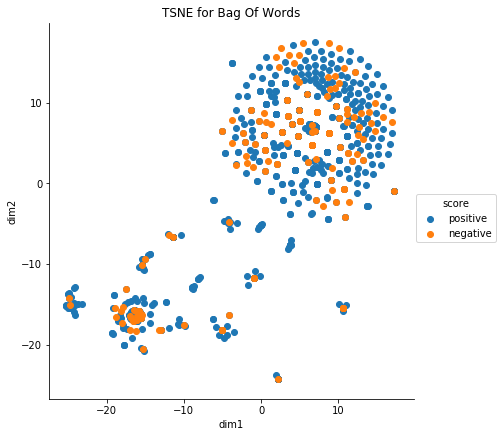

In [40]:
from sklearn.manifold import TSNE
tmodel = TSNE(n_components = 2 , random_state=0,perplexity=20,n_iter=1000)
tsne_data = tmodel.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag Of Words")
plt.show()


# TF-IDF

In [41]:
#tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect=TfidfVectorizer()
final_tf_idf_vect=tf_idf_vect.fit_transform(final_data["CleanedText"].values)
final_tf_idf_vect.get_shape()
#get features
features=tf_idf_vect.get_feature_names()
print(len(features))
print("type of count vectorizer :",type(final_tf_idf_vect))

120765
type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>


In [42]:
#top tdf-idf features code taken from https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf_vect[1,:].toarray()[0],features,25)

In [43]:
top_tfidf

,feature,tfidf
0,sendak,0.341022
1,paperback,0.330529
2,rosi,0.304009
3,flimsi,0.245919
4,incorpor,0.234208
5,them,0.229714
6,page,0.210994
7,movi,0.200920
8,book,0.191414
9,grew,0.185494


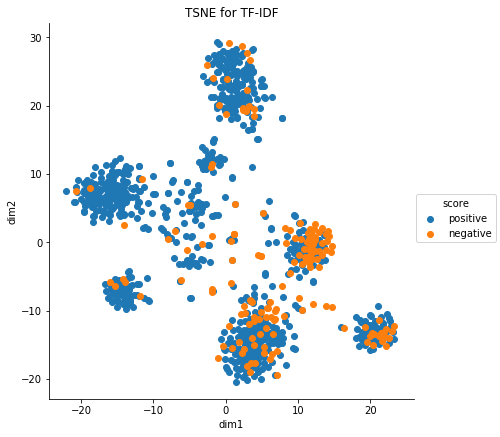

In [45]:
#t-SNE visualization for tf-idf
n_samples=1000
std_data=final_tf_idf_vect[0:n_samples,:].todense()
label_data=final_data["Score"][0:n_samples]

#from sklearn.manifold import TSNE

tmodel=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=4000)
tsne_data=tmodel.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, label_data)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))


sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF")
plt.show()